بسم الله الرحمن الرحيم

# Data

## Download data

In [30]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("omkargurav/face-mask-dataset")

print("Path to dataset files:", path)

Using Colab cache for faster access to the 'face-mask-dataset' dataset.
Path to dataset files: /kaggle/input/face-mask-dataset


## Load data

In [31]:
import os
import pandas as pd

In [32]:
WithMaskPath = "/kaggle/input/face-mask-dataset/data/with_mask"
WithOutMaskPath = "/kaggle/input/face-mask-dataset/data/without_mask"

In [33]:
os.listdir(WithMaskPath)

['with_mask_3326.jpg',
 'with_mask_3139.jpg',
 'with_mask_696.jpg',
 'with_mask_2867.jpg',
 'with_mask_39.jpg',
 'with_mask_1811.jpg',
 'with_mask_532.jpg',
 'with_mask_1619.jpg',
 'with_mask_3471.jpg',
 'with_mask_3501.jpg',
 'with_mask_1874.jpg',
 'with_mask_1825.jpg',
 'with_mask_3499.jpg',
 'with_mask_2392.jpg',
 'with_mask_1236.jpg',
 'with_mask_2147.jpg',
 'with_mask_579.jpg',
 'with_mask_732.jpg',
 'with_mask_557.jpg',
 'with_mask_3331.jpg',
 'with_mask_1343.jpg',
 'with_mask_3252.jpg',
 'with_mask_48.jpg',
 'with_mask_680.jpg',
 'with_mask_551.jpg',
 'with_mask_2380.jpg',
 'with_mask_131.jpg',
 'with_mask_3638.jpg',
 'with_mask_411.jpg',
 'with_mask_3428.jpg',
 'with_mask_2335.jpg',
 'with_mask_239.jpg',
 'with_mask_385.jpg',
 'with_mask_2325.jpg',
 'with_mask_337.jpg',
 'with_mask_3334.jpg',
 'with_mask_3669.jpg',
 'with_mask_2624.jpg',
 'with_mask_3567.jpg',
 'with_mask_489.jpg',
 'with_mask_3596.jpg',
 'with_mask_3110.jpg',
 'with_mask_3187.jpg',
 'with_mask_3339.jpg',
 'wit

In [34]:
# Collect all image file paths and labels
WithMask_files = [os.path.join(WithMaskPath, f) for f in os.listdir(WithMaskPath)]
WithOutMask_files = [os.path.join(WithOutMaskPath, f) for f in os.listdir(WithOutMaskPath)]

In [35]:
# Create labels (1 for WithMask, 0 for WithOutMask)
WithMask_labels = [1] * len(WithMask_files)
WithOutMask_labels = [0] * len(WithOutMask_files)

In [36]:
# Combine into a DataFrame
all_files = WithMask_files + WithOutMask_files
all_labels = WithMask_labels + WithOutMask_labels
df = pd.DataFrame({'filename': all_files, 'class': all_labels})

In [37]:
df.head()

,filename,class
0,/kaggle/input/face-mask-dataset/data/with_mask...,1
1,/kaggle/input/face-mask-dataset/data/with_mask...,1
2,/kaggle/input/face-mask-dataset/data/with_mask...,1
3,/kaggle/input/face-mask-dataset/data/with_mask...,1
4,/kaggle/input/face-mask-dataset/data/with_mask...,1


In [38]:
from sklearn.model_selection import train_test_split
train_df, val_df = train_test_split(df, test_size=0.35, stratify=df['class'], shuffle=True ,random_state=42)

In [39]:
train_df['class'] = train_df['class'].astype(str)
val_df['class'] = val_df['class'].astype(str)

In [40]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [41]:
# ImageDataGenerator for train set with augmented data
datagen_train = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

In [42]:
datagen_valid = ImageDataGenerator(rescale=1./255)

In [43]:
train_generator = datagen_train.flow_from_dataframe(
    dataframe=train_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=True
)

Found 4909 validated image filenames belonging to 2 classes.


In [44]:
validation_generator = datagen_valid.flow_from_dataframe(
    dataframe=val_df,
    x_col='filename',
    y_col='class',
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)

Found 2644 validated image filenames belonging to 2 classes.


# Model

## VGG - 16

In [45]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.utils import plot_model


vgg16_model = VGG16(weights='imagenet')

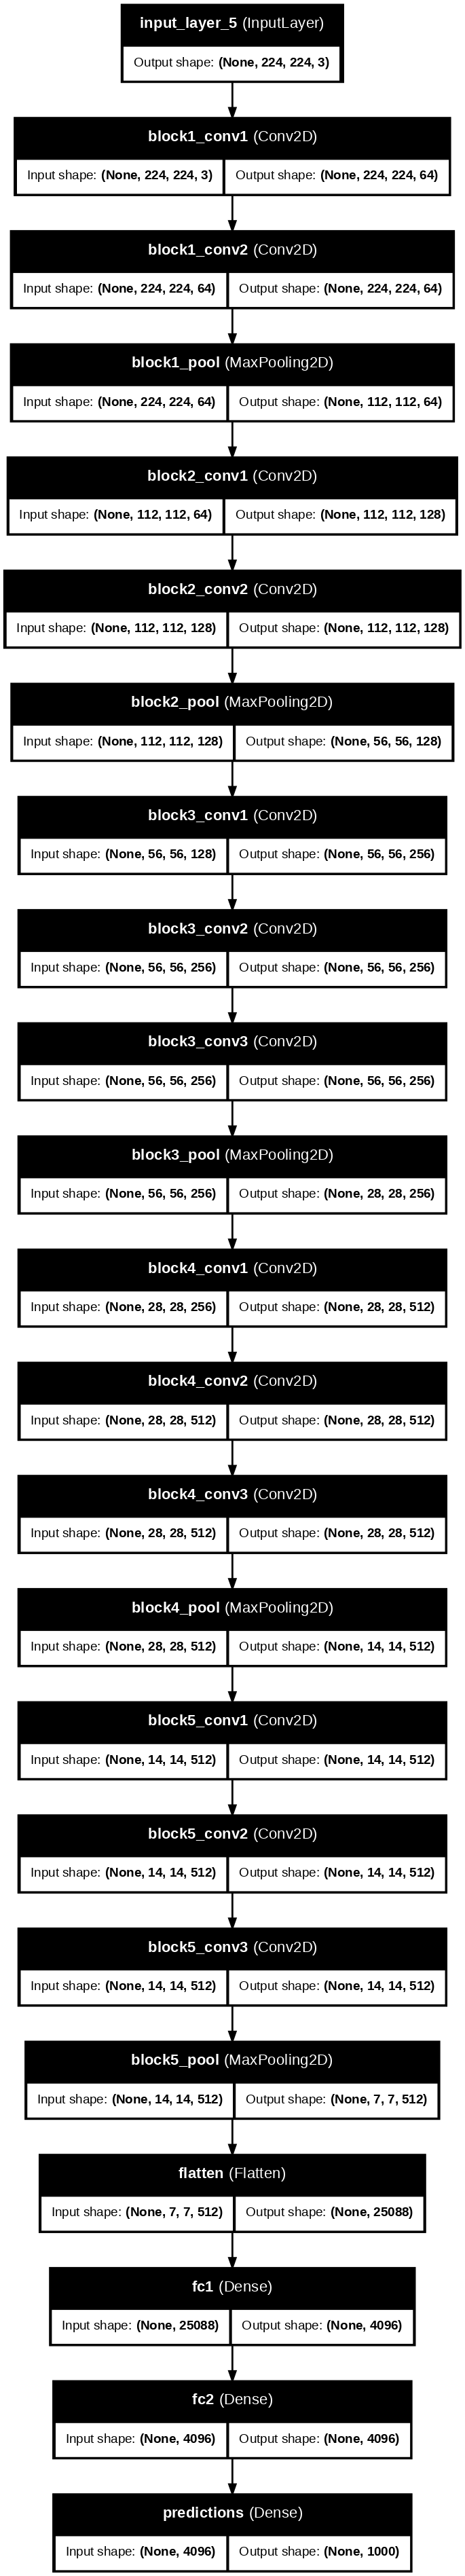

In [46]:
# Add dpi and expand_nested for clearer and more detailed diagrams
plot_model(vgg16_model, to_file='vgg16_model.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=100)

## Transfer

### Base

In [47]:
# Load VGG16 pre-trained on ImageNet, excluding the top classification layer
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

In [48]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Dropout , GlobalAveragePooling2D , Input
from tensorflow.keras.optimizers import Adam

In [49]:
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Flatten, Dense, Dropout, GlobalAveragePooling2D

# Input layer
inputs = Input(shape=(224, 224, 3))

# Base VGG16 (without top layers)
vgg16_base = VGG16(weights="imagenet", include_top=False, input_tensor=inputs)

# Feature extractor output
x = vgg16_base.output

# Flatten or GAP
x = GlobalAveragePooling2D()(x)   # أو Flatten()(x)

# Fully connected layers
x = Dense(1024, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.5)(x)

# Final output
outputs = Dense(1, activation='sigmoid')(x)

# Build Functional API model
transfer_model = Model(inputs=inputs, outputs=outputs)



In [50]:
vgg16_base.trainable =  True

In [51]:
# Freeze the first 1the layers of the VGG16 base
for layer in vgg16_base.layers[:16]:
    layer.trainable = False

In [52]:
len(vgg16_base.layers)

19

### NEW Fully Connected

In [53]:
# Compile the new model
transfer_model.compile(optimizer=Adam(learning_rate=0.001),
                       loss='binary_crossentropy',
                       metrics=['accuracy'])

In [54]:
transfer_model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_2      │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 15,896,385 (60.64 MB)

 Trainable params: 5,901,313 (22.51 MB)

 Non-trainable params: 9,995,072 (38.13 MB)

In [55]:
transfer_model.fit(train_generator,
                   epochs=2,
                   validation_data=validation_generator)

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
 43/154 ━━━━━━━━━━━━━━━━━━━━ 1:25 771ms/step - accuracy: 0.6097 - loss: 0.6717

/usr/local/lib/python3.12/dist-packages/PIL/Image.py:1047: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


154/154 ━━━━━━━━━━━━━━━━━━━━ 144s 786ms/step - accuracy: 0.7857 - loss: 0.4169 - val_accuracy: 0.9852 - val_loss: 0.0504
Epoch 2/2
154/154 ━━━━━━━━━━━━━━━━━━━━ 86s 560ms/step - accuracy: 0.9721 - loss: 0.0820 - val_accuracy: 0.9822 - val_loss: 0.0625


In [60]:
transfer_model.save('myModel.keras')

# VGG - 19

In [57]:

from tensorflow.keras.applications import VGG19

vgg19_model = VGG19(weights='imagenet')


574710816/574710816 ━━━━━━━━━━━━━━━━━━━━ 8s 0us/step


In [59]:
from google.colab import files
files.download('myModel.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [58]:
plot_model(alexnet_model, to_file='alexnet_model.png',
           show_shapes=True,
           show_layer_names=True,
           expand_nested=True,
           dpi=100)

NameError: name 'alexnet_model' is not defined